In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = False)

Mounted at /content/drive


In [ ]:
# extract data from zip file
import zipfile
import os

# Define the path to your zip file and the directory where you want to extract it
zip_file_path = '/content/drive/MyDrive/465 Project/archive.zip'
extract_folder_path = '/content/data'

os.makedirs(extract_folder_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_path)


In [ ]:
# lib imports
import torch
import os
import numpy as np
import pandas as pd
import random
import cv2

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [ ]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, target_size=(128, 128)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.target_size = target_size
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load and preprocess image
        img = cv2.imread(os.path.join(self.image_dir, self.image_files[idx]))
        img = cv2.resize(img, self.target_size)
        img = np.transpose(img, (2, 0, 1))  # Convert to channels-first format
        img = torch.tensor(img, dtype=torch.float32)

        # Load and preprocess mask
        mask = cv2.imread(os.path.join(self.mask_dir, self.mask_files[idx]))
        mask = cv2.resize(mask, self.target_size)
        mask = np.any(mask > 245, axis=2)  # Convert to boolean mask
        mask = mask.astype(np.float32)
        mask = mask[np.newaxis, :, :]  # Add channel dimension
        mask = torch.tensor(mask, dtype=torch.float32)

        return img, mask


In [ ]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):

    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.SE = Squeeze_Excite(out_channels, 8)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.SE(out)

        return out

class Squeeze_Excite(nn.Module):

    def __init__(self, channel, reduction):
        super().__init__()
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avgpool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class UNetPlusPlus(nn.Module):

    def __init__(self, num_classes, input_channels=3, deep_supervision=False, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512]

        self.deep_supervision = deep_supervision

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = ConvBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = ConvBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = ConvBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = ConvBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = ConvBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv0_1 = ConvBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = ConvBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = ConvBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = ConvBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = ConvBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = ConvBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = ConvBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = ConvBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = ConvBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = ConvBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)

    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]

        else:
            output = self.final(x0_4)
            return torch.sigmoid(output)


In [ ]:
# Instantiate the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNetPlusPlus(in_channels=3, num_classes=1, deep_supervision=False).to(device)

In [ ]:
from torchsummary import summary
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           9,248
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              ReLU-6         [-1, 32, 128, 128]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Linear-8                    [-1, 4]             128
              ReLU-9                    [-1, 4]               0
           Linear-10                   [-1, 32]             128
          Sigmoid-11                   [-1, 32]               0
   Squeeze_Excite-12         [-1, 32, 128, 128]               0
        ConvBlock-13         [-1, 32, 128, 128]               0
        MaxPool2d-14           [-1, 32,

In [ ]:
import torch

# Assuming model is an instance of NestedUNet or UNet
dummy_input = torch.randn(16, 3, 128, 128).to(device)  # Creating a dummy input tensor

# Pass the dummy input through the model
model.eval()
with torch.no_grad():
    output = model(dummy_input)

# Convert the output probabilities to binary values (0 or 1)
# binary_output = torch.round(output)

# Print the binary output
print(output.shape)


torch.Size([16, 1, 128, 128])


In [ ]:
################################

# create the checkpoint path

# checkpoint_path = '/content/checkpoint_path/NesU-GrainsTraining.ckpt'
# os.makedirs("/content/checkpoint_path", exist_ok=True)
# checkpoint_dir = os.path.dirname(checkpoint_path)


In [ ]:
from torch.utils.data import random_split

# Define directories for images and masks
image_dir = '/content/data/Grains'
mask_dir = '/content/data/Segmented'

# Create custom dataset
dataset = CustomDataset(image_dir, mask_dir)


train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define callbacks
class ModelCheckpoint:
    def __init__(self, checkpoint_path):
        self.checkpoint_path = checkpoint_path
        self.best_loss = float('inf')

    def __call__(self, model, epoch, train_loss, val_loss):
        if val_loss < self.best_loss:
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'train_loss' : train_loss,
            'val_loss': val_loss,
            }, self.checkpoint_path)
            print("Checkpoint saved")
            self.best_loss = val_loss

In [ ]:
import os
from datetime import datetime

# Dataset folder name abbreviation
dataset_name = "Ex1-SS316L-Grains-500X"
checkpoint_dir = "/content/drive/MyDrive/465 Project"
checkpoint_dir = os.path.join(checkpoint_dir, dataset_name)


if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


model_name = "UNetPlusPlus"


checkpoint_filename = f'{model_name}_{datetime.now().strftime("%Y%m%d%H%M%S")}.pt'
checkpoint_path = os.path.join(checkpoint_dir, checkpoint_filename)

checkpoint_dir = os.path.dirname(checkpoint_path)
checkpointer = ModelCheckpoint(checkpoint_path)


print(f"Check point path: {checkpoint_path}")


Check point path: /content/drive/MyDrive/465 Project/Ex1-SS316L-Grains-500X/UNetPlusPlus_20240402065716.pt


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()


# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
# Use train_loader for training
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

    # Average losses
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Call the ModelCheckpoint callback
    checkpointer(model,epoch, train_loss, val_loss)


Epoch [1/20], Train Loss: 0.4706, Val Loss: 0.4429
Checkpoint saved
Epoch [2/20], Train Loss: 0.4202, Val Loss: 0.4381
Checkpoint saved
Epoch [3/20], Train Loss: 0.3840, Val Loss: 0.3924
Checkpoint saved
Epoch [4/20], Train Loss: 0.3524, Val Loss: 0.3802
Checkpoint saved
Epoch [5/20], Train Loss: 0.3283, Val Loss: 0.3543
Checkpoint saved
Epoch [6/20], Train Loss: 0.3109, Val Loss: 0.3409
Checkpoint saved
Epoch [7/20], Train Loss: 0.2893, Val Loss: 0.3171
Checkpoint saved
Epoch [8/20], Train Loss: 0.2759, Val Loss: 0.3419
Epoch [9/20], Train Loss: 0.2653, Val Loss: 0.3311
Epoch [10/20], Train Loss: 0.2597, Val Loss: 0.3010
Checkpoint saved
Epoch [11/20], Train Loss: 0.2481, Val Loss: 0.2988
Checkpoint saved
Epoch [12/20], Train Loss: 0.2393, Val Loss: 0.3670
Epoch [13/20], Train Loss: 0.2328, Val Loss: 0.2877
Checkpoint saved
Epoch [14/20], Train Loss: 0.2185, Val Loss: 0.2928
Epoch [15/20], Train Loss: 0.2142, Val Loss: 0.2986
Epoch [16/20], Train Loss: 0.2182, Val Loss: 0.3318
Epoch [

In [ ]:
model.eval()

UNetPlusPlus(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode='bilinear')
  (conv0_0): ConvBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (SE): Squeeze_Excite(
      (avgpool): AdaptiveAvgPool2d(output_size=1)
      (fc): Sequential(
        (0): Linear(in_features=32, out_features=4, bias=False)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=4, out_features=32, bias=False)
        (3): Sigmoid()
      )
    )
  )
  (conv1_0): ConvBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm

In [ ]:
import pandas as pd
import torch

# Load the saved model checkpoint

checkpoint_path = '/content/drive/MyDrive/465 Project/Ex1-SS316L-Grains-500X/UNetPlusPlus_20240402065716.pt'  # Adjust this path accordingly

checkpoint = torch.load(checkpoint_path)
# print(checkpoint.keys())

# Extract specific information from the checkpoint
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']

# Create a DataFrame for the training and validation loss
loss_data = {'Epoch': [epoch], 'Training Loss': [train_loss], 'Validation Loss': [val_loss]}
loss_df = pd.DataFrame(loss_data)

# Print the DataFrame in Markdown table format
print(loss_df.to_markdown(index=False))

|   Epoch |   Training Loss |   Validation Loss |
|--------:|----------------:|------------------:|
|      12 |         0.23281 |          0.287692 |


In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 73.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
from torchmetrics.functional import dice
from torchmetrics.functional import jaccard_index

total_jaccard_score = 0.0
total_dice_score = 0.0
total_num_samples = 0

for images, masks in val_loader:
    batch_size = images.size(0)  # Get the actual batch size
    total_num_samples += batch_size

    with torch.no_grad():
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        preds = model(images)

        for ind in range(len(preds)):
            pred_tensor = (preds[ind] > 0.5).float()
            gt_tensor = masks[ind].to(torch.int64)  # Convert mask tensor to integer tensor

            dice_score = dice(pred_tensor, gt_tensor)
            total_dice_score += dice_score.item()

            jaccard_score = jaccard_index(pred_tensor, gt_tensor, task='binary')
            total_jaccard_score += jaccard_score.item()

average_dice_score = total_dice_score / total_num_samples
average_jaccard_score = total_jaccard_score / total_num_samples


print(f"Total Number samples: {total_num_samples}")
print(f"Average Dice Score: {average_dice_score}")
print(f"Average Jaccard Index: {average_jaccard_score}")

Total Number samples: 68
Average Dice Score: 0.8829478682840571
Average Jaccard Index: 0.7911811295677634


In [ ]:
# Custom Dice

def dice_coef(output, target):
    smooth = 1e-5

    output = torch.sigmoid(output).view(-1).data.cpu().numpy()
    target = target.view(-1).data.cpu().numpy()
    intersection = (output * target).sum()

    return (2. * intersection + smooth) / \
        (output.sum() + target.sum() + smooth)

total_dice_score = 0.0
total_num_samples = 0

for images, masks in val_loader:
    batch_size = images.size(0)
    total_num_samples += batch_size

    with torch.no_grad():
        images = images.to(device)
        masks = masks.to(device)

        preds = model(images)

        for ind in range(len(preds)):
            pred_tensor = preds[ind]
            gt_tensor = masks[ind]

            dice_score = dice_coef(pred_tensor, gt_tensor)
            total_dice_score += dice_score.item()

average_dice_score = total_dice_score / total_num_samples

print(f"Custom Avg Dice Score: {average_dice_score}")


Custom Avg Dice Score: 0.6493268047094547


In [ ]:
# import pandas as pd
# import torch

# # Load the saved model checkpoint
# # checkpoint_path = '/content/drive/MyDrive/465 project demo 1/Unet++ ckpts/GrainsTraining30032024 19_56_28.pt'  # Adjust this path accordingly
# checkpoint_path = '/content/drive/MyDrive/465 Project/GrainsTraining31032024 17:11:23.pt'  # Adjust this path accordingly

# checkpoint = torch.load(checkpoint_path)
# # print(checkpoint.keys())

# # Extract specific information from the checkpoint
# epoch = checkpoint['epoch']
# train_loss = checkpoint['train_loss']
# val_loss = checkpoint['val_loss']

# # Create a DataFrame for the training and validation loss
# loss_data = {'Epoch': [epoch], 'Training Loss': [train_loss], 'Validation Loss': [val_loss]}
# loss_df = pd.DataFrame(loss_data)

# # Print the DataFrame in Markdown table format
# print(loss_df.to_markdown(index=False))


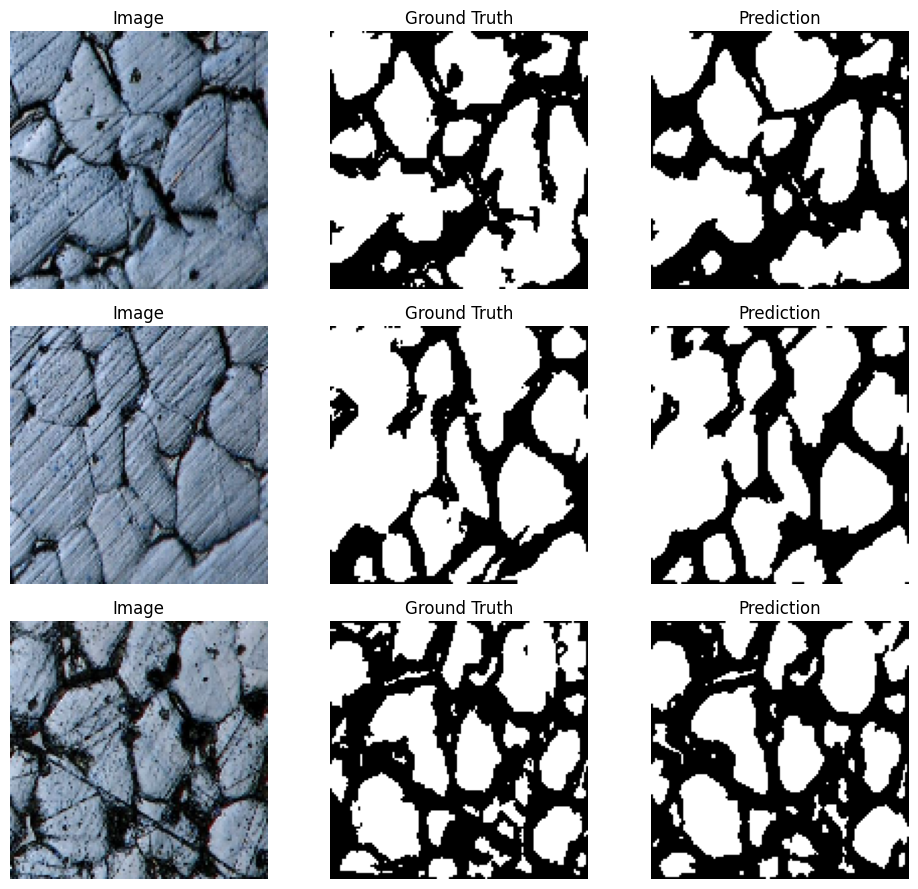

In [ ]:
def plot_example(data_loader, model, device, num_examples=3):
    model.eval()  # Set model to evaluation mode
    images, masks = next(iter(data_loader))  # Get a batch of images and masks from the data loader
    images, masks = images.to(device), masks.to(device)

    with torch.no_grad():  # Disable gradient computation
        outputs = model(images)  # Generate predictions
        outputs = torch.round(outputs)  # Convert probabilities to binary values

    images = images.cpu().numpy()  # Convert tensors to numpy arrays for plotting
    masks = masks.cpu().numpy()
    outputs = outputs.cpu().numpy()

    # Plotting
    fig, axs = plt.subplots(num_examples, 3, figsize=(10, num_examples*3))
    for i in range(num_examples):
        img = np.transpose(images[i], (1, 2, 0))  # Convert from CHW to HWC format for matplotlib
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1] for displaying
        mask = masks[i].squeeze()  # Remove channel dimension from mask
        output = outputs[i].squeeze()  # Remove channel dimension from output

        if num_examples == 1:
            axs[0].imshow(img)
            axs[0].set_title("Image")
            axs[0].axis('off')

            axs[1].imshow(mask, cmap='gray')
            axs[1].set_title("Ground Truth")
            axs[1].axis('off')

            axs[2].imshow(output, cmap='gray')
            axs[2].set_title("Prediction")
            axs[2].axis('off')
        else:
            axs[i, 0].imshow(img)
            axs[i, 0].set_title("Image")
            axs[i, 0].axis('off')

            axs[i, 1].imshow(mask, cmap='gray')
            axs[i, 1].set_title("Ground Truth")
            axs[i, 1].axis('off')

            axs[i, 2].imshow(output, cmap='gray')
            axs[i, 2].set_title("Prediction")
            axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to plot the examples
plot_example(val_loader, model, device, num_examples=3)


In [ ]:
### sure na akhono

def dice_coef(output, target):
    smooth = 1e-5

    output = torch.sigmoid(output).view(-1).data.cpu().numpy()
    target = target.view(-1).data.cpu().numpy()
    intersection = (output * target).sum()

    return (2. * intersection + smooth) / \
        (output.sum() + target.sum() + smooth)

def evaluate_model(model, data_loader, device):
    model.eval()  # Set model to evaluation mode
    total_dice = 0
    with torch.no_grad():  # Disable gradient computation
        for images, masks in data_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            dice_score = dice_coef(outputs, masks)
            total_dice += dice_score.item()

    average_dice = total_dice / len(data_loader)
    return average_dice

# Call the evaluation function
average_dice = evaluate_model(model, val_loader, device)
print(f'Average Dice Coefficient: {average_dice:.4f}')